## *Pré-processamento*

Esta é uma etapa importante do processamento de dados, que envolve vários conceitos. No pré-processamento, os dados podem ser "limpados", padronizados e transformados.

- *Limpar* os dados refere-se à remoção ou correção de dados que estejam incompletos, corrompidos ou imprecisos.
- *Padronizar* os dados refere-se à remoção de *outliers*, além de deixar todas as possíveis mensurações na mesma escala e unidade, além de normalizá-las quando necerrário.
- *Transformar* os dados refere-se à aplicação dos dados em um formato que favoreça futuras extrações de características ou análises.

In [50]:
# Realização de imports necessários
#import sys;
#sys.path.append('/usr/lib/python3/dist-packages')
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
from scipy import signal
from scipy.signal import iirfilter
from scipy.signal import stft, resample, welch
from scipy.fft import fft
from copy import deepcopy as cp

FS=250

## Obtenção dos dados nos domínios básicos...

### (1) Tempo:

In [35]:
data = np.load('datasets/OpenBCI_GUI-v5-meditation.npy')
print(data.shape[0])
data.shape[0] / 8
X = data.swapaxes(1, 0)

# domínio do tempo
X.shape

175952


(8, 175952)

### (2) Frequência:

In [36]:
w = fft(X)
w.shape

(8, 175952)

### (3) Espectrograma:

In [37]:
f, t, Zxx = stft(X, fs=FS, nperseg=256)
print(f.shape, t.shape, Zxx[7,:,:].shape)

# domínio da frequência x tempo (espectrograma)
Zxx.shape

(129,) (1376,) (129, 1376)


(8, 129, 1376)

## Algumas funções extras para avaliar ...

- Utilizar o `scipy.signal.welch` para obter as Frequências em PSD com o método Welch, e comparar com os dados (no gráfico) com dados de frequências obtidas com `scipy.signal.stft` $\rightarrow$ PSD *handcrafted*
- Imprimir apenas "partes importantes" do sinal no domínio da frequência
- Fazer um "merge" dos resultados obtidos pelos alunos nas tarefas e desafio.

## Desenvolvimento de funções para `plot`

Vamos criar uma função que será utilizada como padrão para imprimir os gráficos no domíno do tempo e da frequência.

**Obs.:** Para imprimir os dados no domínio da frequência, foi utilizado a função `matplotlib.pyplot.psd` que na verdade utiliza a transformação dos dados pelo método Welch, porém aplica uma característica que evidencia a "energia" dos dados, chamado de PSD (_Power Spectrum Density_).

**Obs. 2:** Também é realizado o plot do "espectrograma" por meio de uma `NFFT`.

In [38]:
def print_graphs(data):
    for i in range(data.shape[0]):
        plt.plot(data[i,:])
    plt.title('Domínio do tempo')
    plt.show()

    for i in range(data.shape[0]):
        plt.psd(data[i,:], Fs=FS)
    plt.title('Domínio da frequência')
    plt.show()
    
    for i in range(data.shape[0]):
        plt.specgram(data[i,:], Fs=FS)
    plt.title('Espectrograma')
    plt.show()

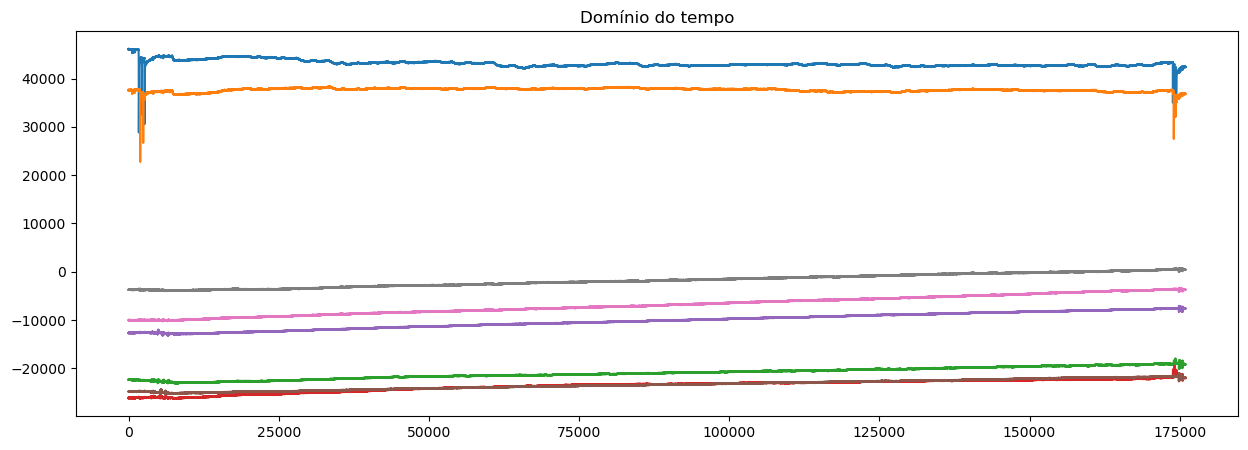

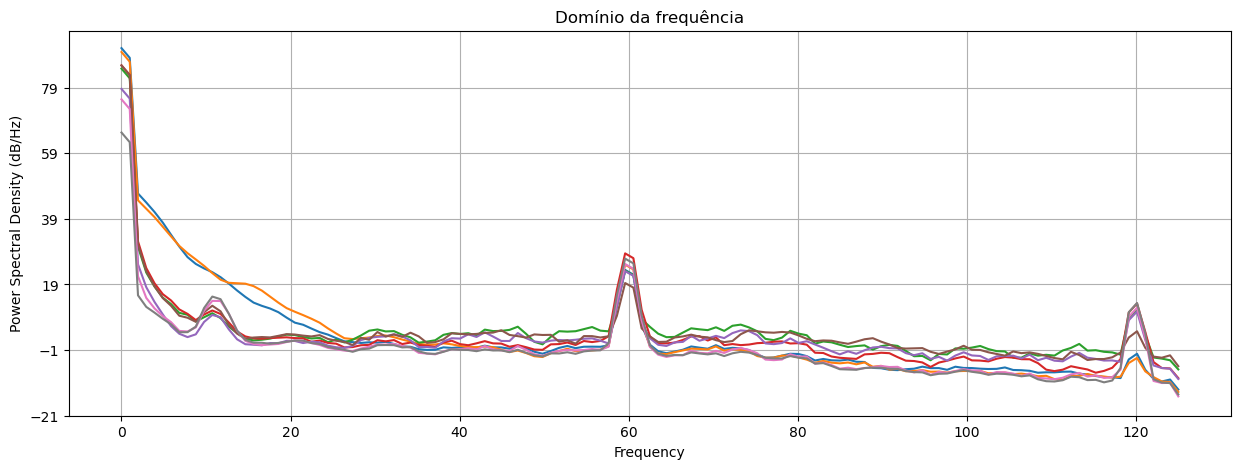

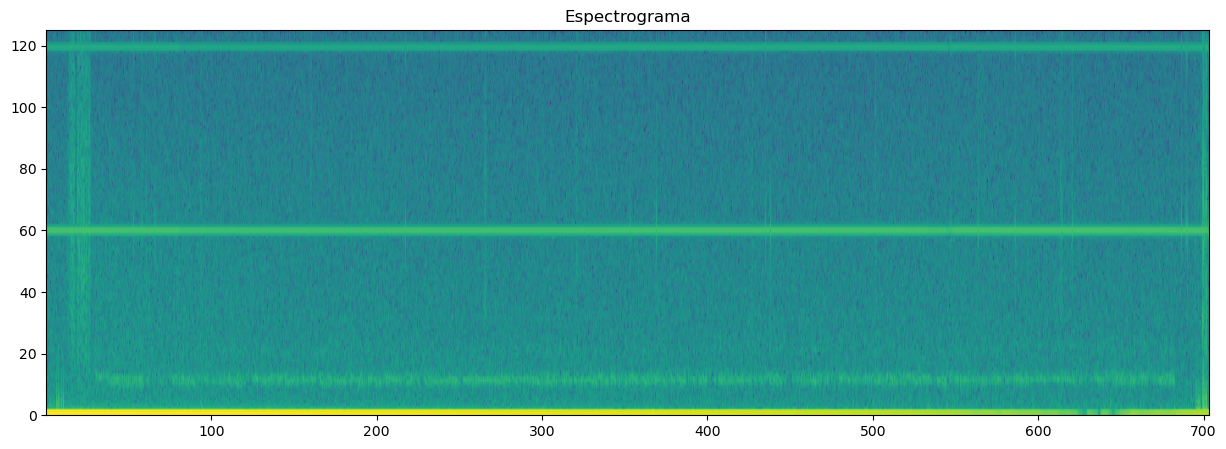

In [39]:
rcParams['figure.figsize'] = [15., 5.]
print_graphs(X)

O gráfico no domínio do tempo causa a impressão de linearidade, pois a quantidade de dados é grande e a magnitude  dos canais são diferentes. Para se ter uma ideia melhor do sinal no domínio do tempo, vamos imprimir apenas um canal com 10% dos dados:

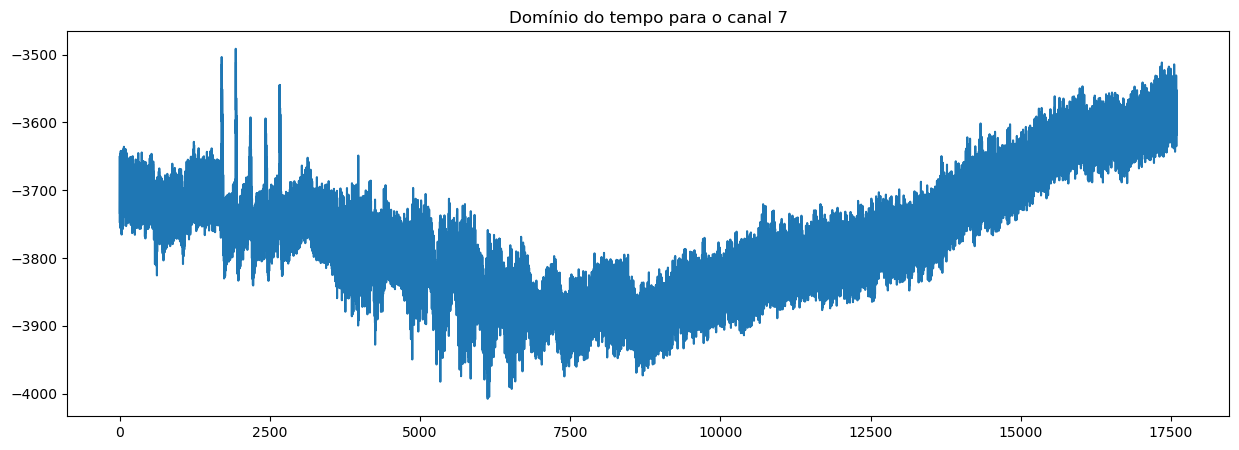

In [40]:
ch = 7
plt.plot(X[ch,:int(X.shape[1]/10)])
plt.title(f'Domínio do tempo para o canal {ch}')
plt.show()

Não é muito justo cortar o começo ou meio do sinal. Então há uma operação que realiza está operação mais uniformemente. Tal operação é chamada de **reamostragem** ou `resample`. Exemplo:

In [41]:
X_rs = resample(X, int(X.shape[1]/10), axis=-1)
print(X_rs.shape, X.shape)

(8, 17595) (8, 175952)


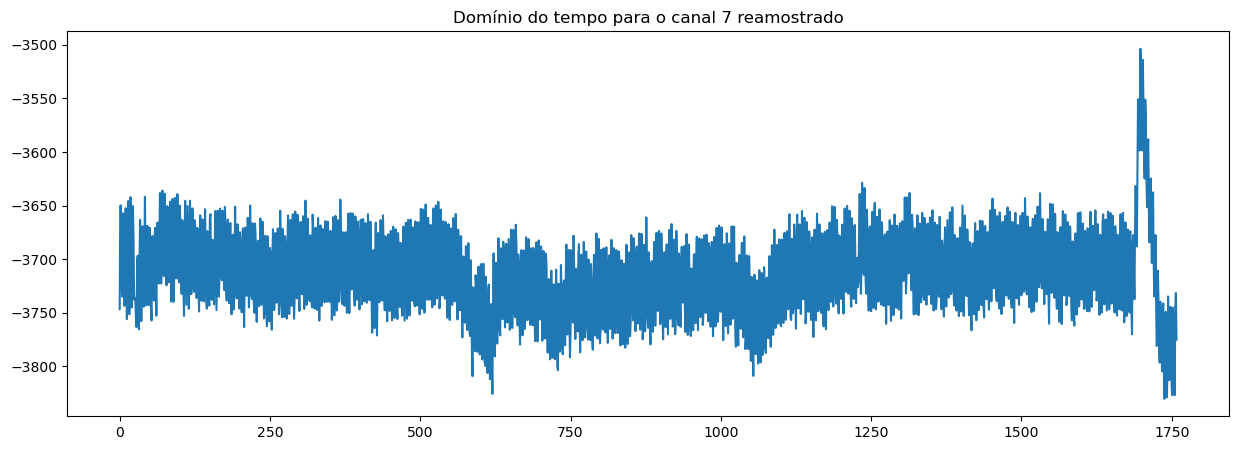

In [42]:
plt.plot(X[ch,:int(X_rs.shape[1]/10)])
plt.title(f'Domínio do tempo para o canal {ch} reamostrado')
plt.show()

**Tarefa**:
- Fazer a média dos 8 eletrodos e realizar os plots de todos os domínios

## Aplicação dos filtros temporais

Para a aplicação dos filtros temporais, serão utilizadas as seguintes funções a seguir:

In [43]:
def butter_bandpass(data, lowcut, highcut, fs=FS, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    return signal.filtfilt(b, a, data)


def butter_lowpass(data, lowcut, fs=FS, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='lowpass')
    return signal.filtfilt(b, a, data)


def butter_highpass(data, highcut, fs=FS, order=4):
    nyq = fs * 0.5
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='highpass')
    return signal.filtfilt(b, a, data)


def butter_notch(data, cutoff, var=1, fs=FS, order=4):
    nyq = fs * 0.5
    low = (cutoff - var) / nyq
    high = (cutoff + var) / nyq
    b, a = signal.iirfilter(order, [low, high], btype='bandstop', ftype="butter")
    return signal.filtfilt(b, a, data)


### Apresentação do sinal com a aplicação do filtro "notch"

In [82]:
# ToDo: aplicar filtro em um dado com cópia profunda
cpData = cp(X)

butter_notch(cpData, 50)

array([[ 45996.95676169,  46075.10201599,  46157.11770934, ...,
         42448.45484991,  42502.7176721 ,  42470.0165897 ],
       [ 37486.36380565,  37575.00774903,  37689.09860356, ...,
         36848.23874485,  36893.37579113,  36850.52098565],
       [-22369.95357075, -22259.84449516, -22231.41589983, ...,
        -19131.7809976 , -19097.77657132, -19149.33478134],
       ...,
       [-24777.08241194, -24709.88905772, -24740.68427578, ...,
        -21856.90401609, -21893.22196582, -21927.92595899],
       [-10055.28490649,  -9975.359467  ,  -9975.75285363, ...,
         -3700.54631747,  -3701.38551432,  -3733.9059721 ],
       [ -3747.10139844,  -3648.92932192,  -3648.61083275, ...,
           488.64441213,    488.32097636,    446.09064906]])

### Apresentação do sinal com a aplicação do filtro "bandpass"

In [83]:
# ToDo: aplicar filtro em um dado com cópia profunda
cpData = cp(X)

butter_bandpass(cpData, 5, 35)

array([[ -1.34740319,  48.41057765,  80.68273238, ..., -13.32168465,
         -6.97396077,   1.98937752],
       [ -2.16717265,  60.74730272, 101.43335051, ...,  -8.10733701,
         -4.17546515,   1.88917286],
       [  2.04716096,  48.78380061,  78.87984381, ...,  -5.34428402,
         -2.6131388 ,   0.30881728],
       ...,
       [  2.64004967,  16.04081633,  24.80334614, ...,  29.05039474,
         19.27333908,   2.36918555],
       [  3.17248581,  30.91638015,  49.17303601, ...,   5.71226363,
          3.96020791,   0.93063705],
       [  2.75265836,  35.88208932,  57.73594222, ...,   6.78900693,
          5.0268587 ,   1.16087873]])

### Apresentação do sinal com a aplicação do filtro "notch", seguido por "lowpass" e "highpass"

In [89]:
# ToDo: aplicar o conjunto de filtros em um dado com cópia profunda

cpData = cp(X)

butter_notch(cpData, 50)
butter_lowpass(cpData, 5)
finalData = butter_highpass(cpData, 35)
print(finalData)

[[ 2.09066401e-01  2.40210024e+01  6.73693980e+01 ... -2.30138642e+00
   4.46641403e+01  5.02553989e-01]
 [ 2.75892673e-01  1.98474223e+01  8.38770078e+01 ...  2.90639727e+00
   4.65620392e+01  6.60673195e-01]
 [ 1.58545909e-01  5.76775985e+01  5.11307947e+01 ...  2.06897989e+01
   5.54353979e+01  6.95123650e-01]
 ...
 [-1.12070910e-03  5.20855117e+01  1.37718352e+01 ...  4.02014438e+01
   2.03635210e+01  2.47444986e-01]
 [ 6.83873936e-02  4.67202279e+01  2.60809190e+01 ...  2.58817278e+01
   3.09782713e+01  3.97792827e-01]
 [ 7.74858855e-02  5.92482020e+01  3.42618535e+01 ...  3.28288777e+01
   4.00478296e+01  4.71560959e-01]]


### Apresentação do sinal com a aplicação do filtro "notch", seguido por "lowpass" e "highpass" 10 vezes

In [94]:
# ToDo: aplicar o conjunto de filtros em um dado com cópia profunda em um laço

cpData = cp(X)
x = butter_notch(cpData, 50)

i=1
for i in range(11):
    x = butter_lowpass(x, 5)
    x = butter_highpass(x, 35)

print(x)

[[-8.04534029e-47  2.74995113e-47  7.77036352e-47 ... -4.10167727e-70
  -6.36462061e-70  3.50344324e-73]
 [-1.14229619e-46  3.90444094e-47  1.10325412e-46 ... -6.92551640e-71
  -1.05830430e-70  6.47400990e-74]
 [-6.65741271e-47  2.27554859e-47  6.42987331e-47 ... -9.22852257e-71
  -1.41074783e-70  8.61390479e-74]
 ...
 [ 1.40627876e-47 -4.80660659e-48 -1.35820554e-47 ...  2.64667723e-70
   4.13715520e-70 -2.15710432e-73]
 [-3.30280318e-47  1.12892330e-47  3.18992053e-47 ...  3.32982580e-71
   5.42364934e-71 -1.96259225e-74]
 [-4.35101263e-47  1.48720323e-47  4.20230083e-47 ...  8.43625021e-71
   1.33297582e-70 -6.38418064e-74]]


### Apresentação do sinal com a aplicação do filtro "notch", seguido por "lowpass" e "highpass" 10 vezes em gráficos separados

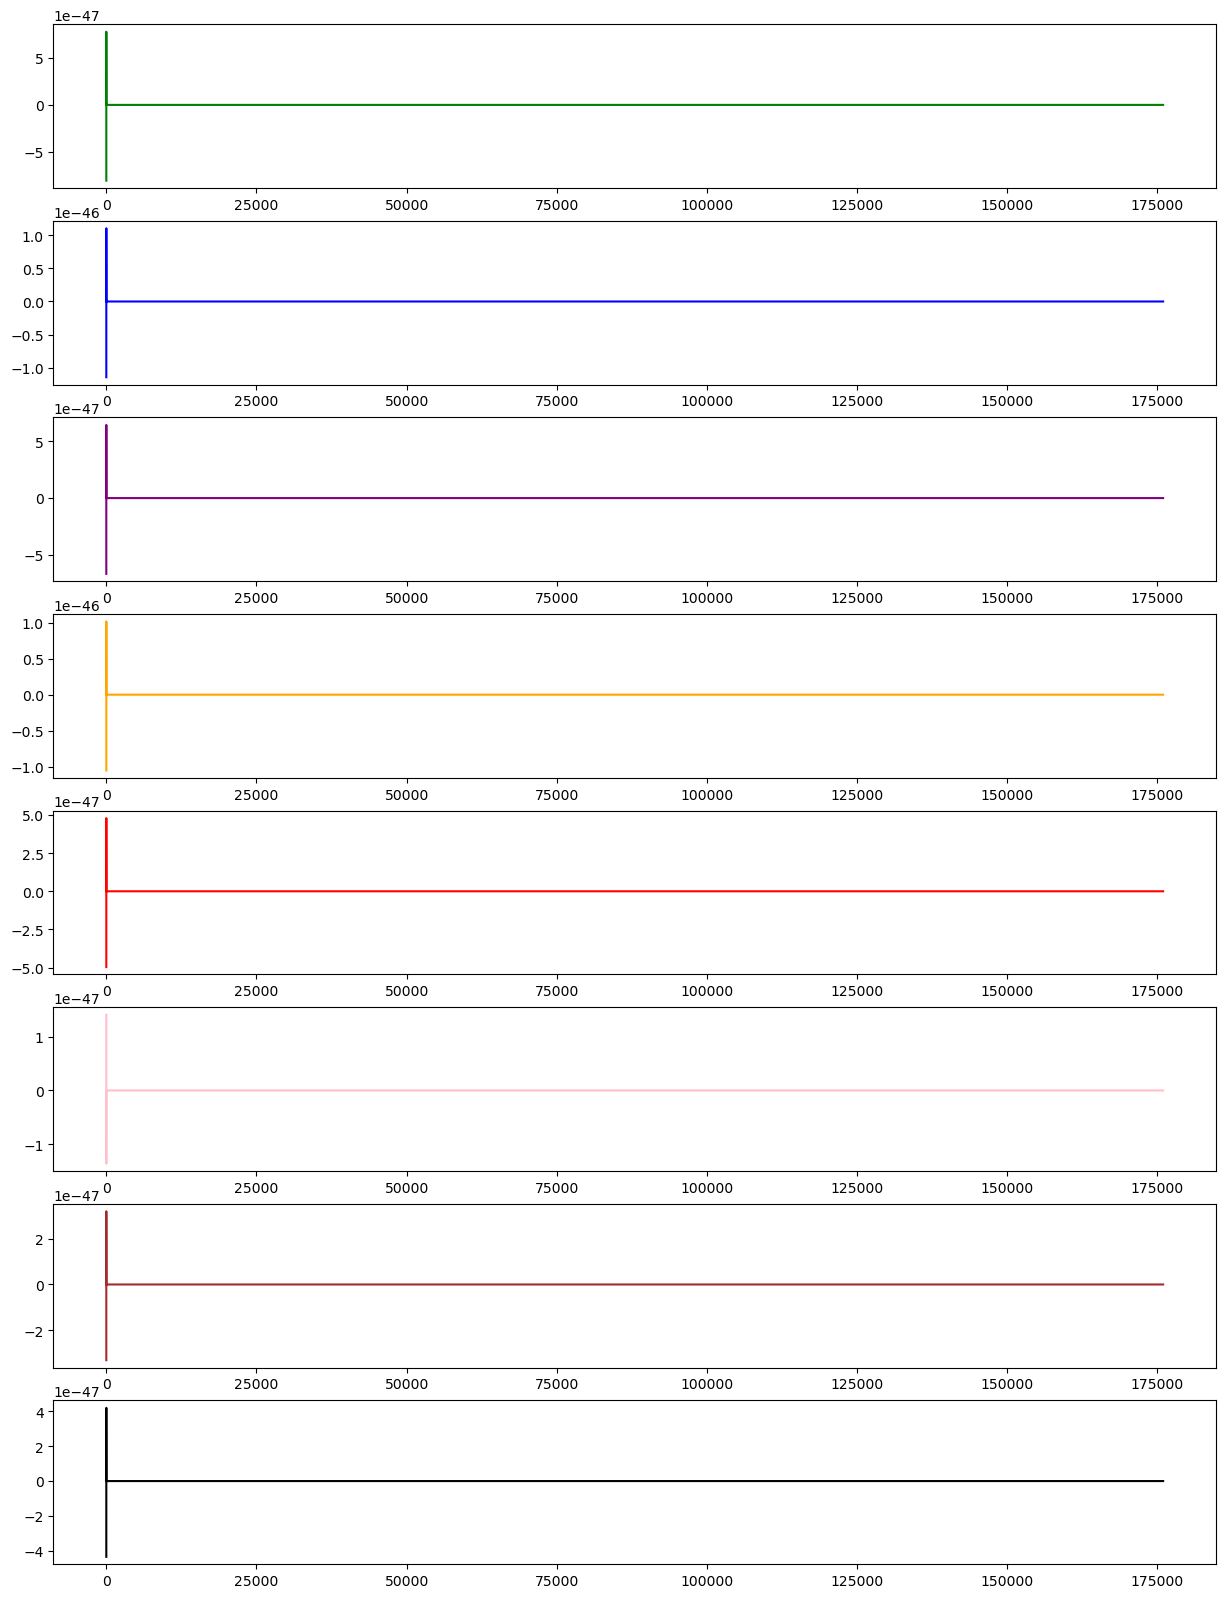

In [95]:
# ToDo: adequar dados e aplicar o conjunto de filtros em um dado com cópia profunda em um laço

rcParams['figure.figsize'] = [15., 20.]
fig, axes = plt.subplots(8, 1)
colors = ('green', 'blue', 'purple', 'orange', 'red', 'pink', 'brown', 'black')
for i, ax in enumerate(axes.flatten()):
    ax.plot(x[i,:], color=colors[i])

**Tarefas**:
1. Refaça o gráfico dos dados filtrados no domínio do tempo com uma **reamostragem** adequada.
2. Grave os dados filtrados (analise a melhor faixa de frequência para a aplicação desejada) em um novo arquivo numpy

**Desafio**:
- Analise gráficos de canais separados no domínio da frequência e tire conclusões sobre a aplicação de um **filtro espacial**.